# Krystyn Gutu

### Introduction to Data Science | Professor Sarbanes | Final Project | Friday, May 6, 2022

In [1]:
pip install prophet

In [2]:
import numpy as nm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

#### Implement a Time Series Forecasting model in Python, by using the FBProphet module. The forecasting model should be able to predict the Sunspots (see below) by using Facebook’s Prophet Time Series Forecasting model.Source: https://en.wikipedia.org/wiki/Sunspot
#### Yearly data: http://www.sidc.be/silso/infosnytot


## YEARLY TIMESERIES

In [3]:
yearly = pd.read_csv("SN_y_tot_V2.0.csv")

### Analyzing the Data

In [4]:
yearly.head()

,1700.5; 8.3; -1.0; -1;1
0,1701.5; 18.3; -1.0; -1;1
1,1702.5; 26.7; -1.0; -1;1
2,1703.5; 38.3; -1.0; -1;1
3,1704.5; 60.0; -1.0; -1;1
4,1705.5; 96.7; -1.0; -1;1


In [5]:
yearly.shape

(321, 1)

In [6]:
yearly.columns

Index(['1700.5;   8.3; -1.0;    -1;1'], dtype='object')

In [7]:
annually = yearly.copy()

In [8]:
annually.isnull().values.any()

False

In [9]:
annually = annually["1700.5;   8.3; -1.0;    -1;1"].str.split(";", expand = True)
annually.head()

,0,1,2,3,4
0,1701.5,18.3,-1.0,-1,1
1,1702.5,26.7,-1.0,-1,1
2,1703.5,38.3,-1.0,-1,1
3,1704.5,60.0,-1.0,-1,1
4,1705.5,96.7,-1.0,-1,1


In [10]:
annually.shape

(321, 5)

In [11]:
annually = annually.rename(columns = {0: "midyear_date", 1: "yearly_mean_sunspots", 2: "yearly_sunspot_std", 3: "observations", 
                        4: "indicator"})
annually.head()

,midyear_date,yearly_mean_sunspots,yearly_sunspot_std,observations,indicator
0,1701.5,18.3,-1.0,-1,1
1,1702.5,26.7,-1.0,-1,1
2,1703.5,38.3,-1.0,-1,1
3,1704.5,60.0,-1.0,-1,1
4,1705.5,96.7,-1.0,-1,1


In [12]:
new_row = pd.DataFrame({"midyear_date": "1700.5", "yearly_mean_sunspots": "8.3", "yearly_sunspot_std": -1.0,
                        "observations": "-1", "indicator": "1"}, index = [0])

annually = pd.concat([new_row, annually]).reset_index(drop = True)

In [13]:
annually.head()

,midyear_date,yearly_mean_sunspots,yearly_sunspot_std,observations,indicator
0,1700.5,8.3,-1.0,-1,1
1,1701.5,18.3,-1.0,-1,1
2,1702.5,26.7,-1.0,-1,1
3,1703.5,38.3,-1.0,-1,1
4,1704.5,60.0,-1.0,-1,1


In [14]:
annually.columns

Index(['midyear_date', 'yearly_mean_sunspots', 'yearly_sunspot_std',
       'observations', 'indicator'],
      dtype='object')

In [15]:
a = annually.copy()
a.shape

(322, 5)

In [16]:
a.isnull().values.any()

False

### 1) Make your code agnostic of the input. In other words, have your code determine the unit of the time series.

In [17]:
a["midyear_date"] = a["midyear_date"].astype("float")
a["yearly_mean_sunspots"] = a["yearly_mean_sunspots"].astype("float")
a["yearly_sunspot_std"] = a["yearly_sunspot_std"].astype("float")
a["observations"] = a["observations"].astype("float")
a["indicator"] = a["indicator"].astype("float")
a.dtypes

midyear_date            float64
yearly_mean_sunspots    float64
yearly_sunspot_std      float64
observations            float64
indicator               float64
dtype: object

In [18]:
a.tail()

,midyear_date,yearly_mean_sunspots,yearly_sunspot_std,observations,indicator
317,2017.5,21.7,2.5,11444.0,1.0
318,2018.5,7.0,1.1,12611.0,1.0
319,2019.5,3.6,0.5,12884.0,1.0
320,2020.5,8.8,4.1,14440.0,1.0
321,2021.5,29.6,7.9,15233.0,1.0


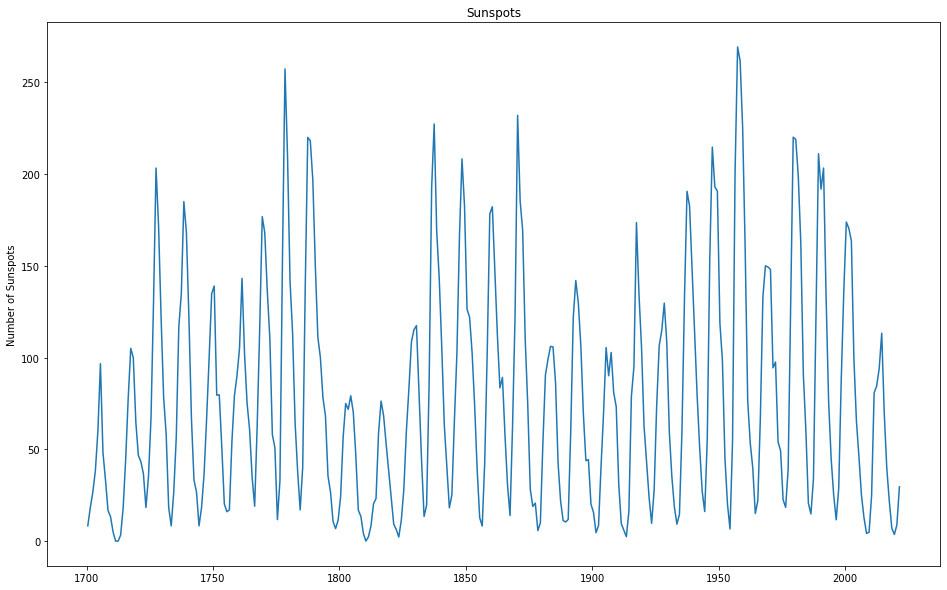

In [19]:
plt.figure(figsize = (16, 10))
plt.plot(a["midyear_date"], a["yearly_mean_sunspots"])
plt.title("Sunspots")
plt.ylabel("Number of Sunspots")
plt.show()

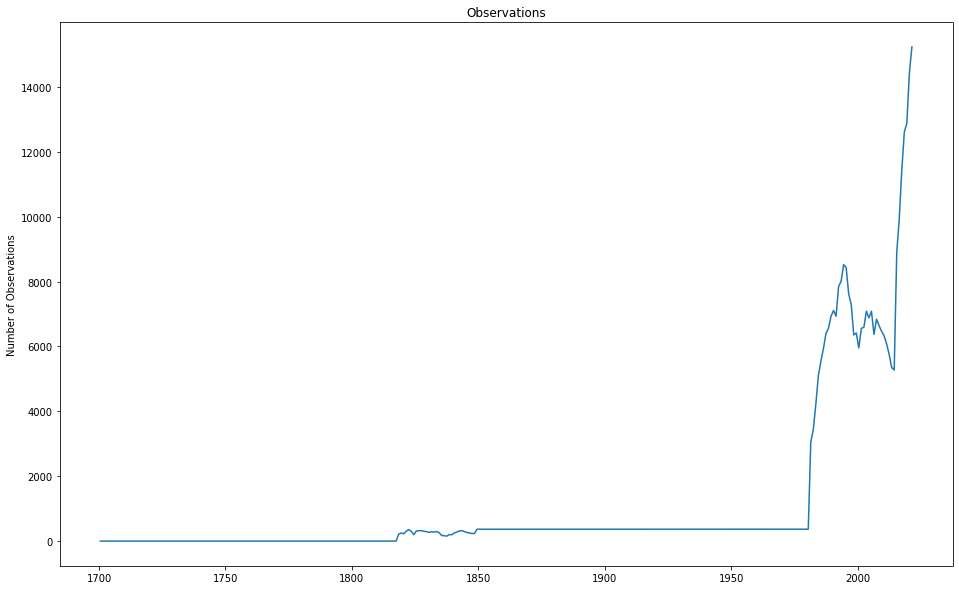

In [20]:
plt.figure(figsize = (16, 10))
plt.plot(a["midyear_date"], a["observations"])
plt.title("Observations")
plt.ylabel("Number of Observations")
plt.show()

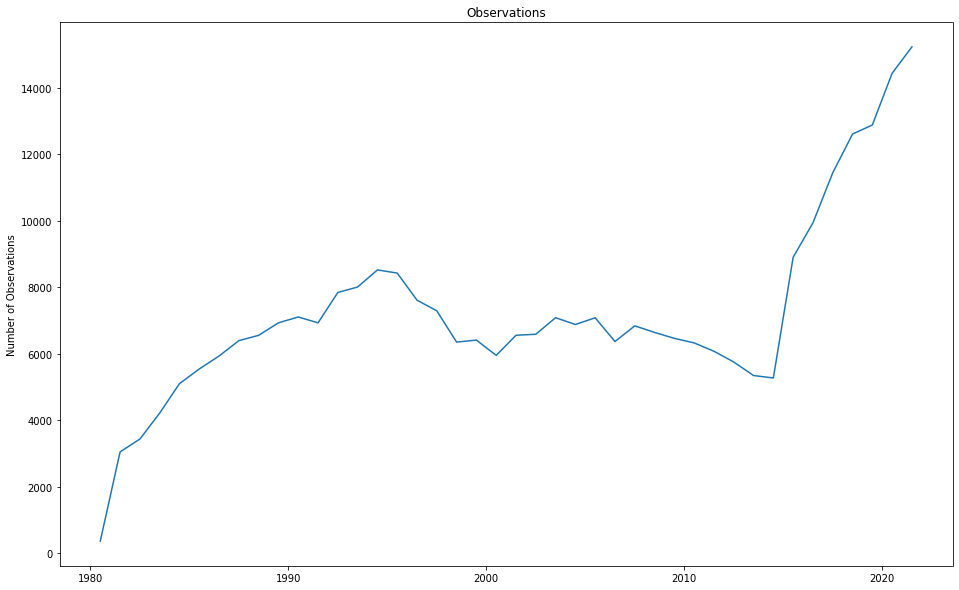

In [21]:
a_zoomed_in = a.loc[a["midyear_date"].between(1980.5, 2022.5)]

plt.figure(figsize = (16, 10))
plt.plot(a_zoomed_in["midyear_date"], a_zoomed_in["observations"])
plt.title("Observations")
plt.ylabel("Number of Observations")
plt.show()

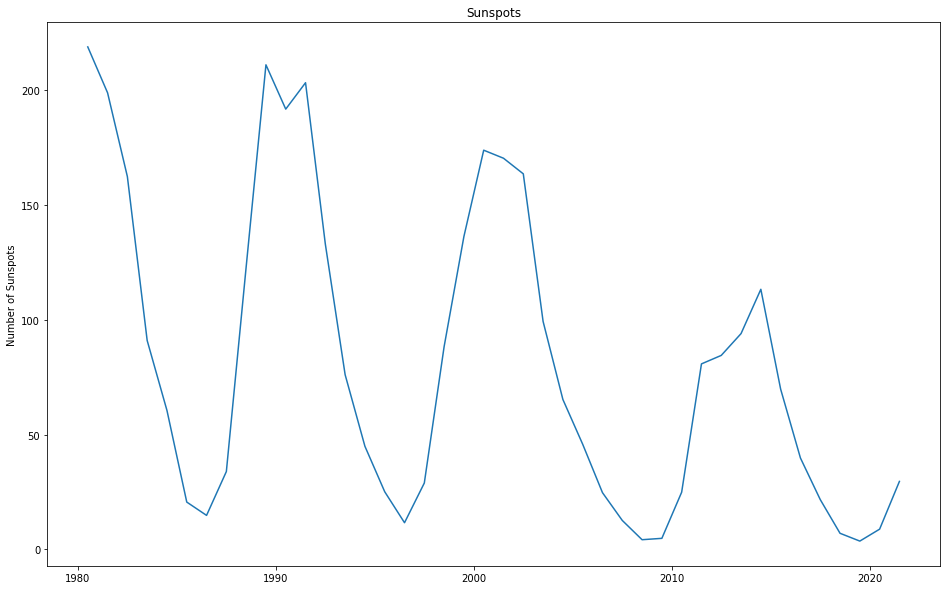

In [22]:
a_zoomed_in = a.loc[a["midyear_date"].between(1980, 2022)]

plt.figure(figsize = (16, 10))
plt.plot(a_zoomed_in["midyear_date"], a_zoomed_in["yearly_mean_sunspots"])
plt.title("Sunspots")
plt.ylabel("Number of Sunspots")
plt.show()

### 2) Train your model and predict the Sunspots values from the last date of the dataset into X units of time into the future. 
Should the unit of time be year, then predict the number of sunspots for 1/10/20 years into the future.

### 3) Tune your FBProphet model on the following parameters: 
#### a) Forecasting growth: Plausible values = logistic; linear; flat https://facebook.github.io/prophet/docs/saturating_forecasts.html
#### b) Seasonality: Add manual seasonality by using the add_seasonality method. Test it with various values for ‘period’ and ‘fourier_order’. https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
#### c) Trend Changepoints: Tune the ‘n_changepoints’ and ‘changepoit_prior_scale’ arguments/parameters https://facebook.github.io/prophet/docs/trend_changepoints.html
#### For each model, print the predicted values in a tabular format and draw a line graph showing both historical data and the future.

In [23]:
a1 = a[["midyear_date", "yearly_mean_sunspots"]]
a1.tail()

,midyear_date,yearly_mean_sunspots
317,2017.5,21.7
318,2018.5,7.0
319,2019.5,3.6
320,2020.5,8.8
321,2021.5,29.6


In [24]:
col_dict = {"midyear_date": "ds", \
            "yearly_mean_sunspots": "y"}

a1.columns = [col_dict.get(x, x) for x in a1.columns]
a1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      322 non-null    float64
 1   y       322 non-null    float64
dtypes: float64(2)
memory usage: 5.2 KB


In [25]:
a1 = a1.assign(y = (a1["y"]))

In [26]:
a1.head()

,ds,y
0,1700.5,8.3
1,1701.5,18.3
2,1702.5,26.7
3,1703.5,38.3
4,1704.5,60.0


#### Seasonality

In [27]:
model = Prophet(yearly_seasonality = True)

In [28]:
model.fit(a1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
s1_future = model.make_future_dataframe(periods = 1)
s1_future.tail()

,ds
318,1970-01-01 00:00:00.000002018
319,1970-01-01 00:00:00.000002019
320,1970-01-01 00:00:00.000002020
321,1970-01-01 00:00:00.000002021
322,1970-01-02 00:00:00.000002021


In [ ]:
s1_pred = model.predict(s1_future)
s1_pred

In [ ]:
model.plot(s1_pred)

In [ ]:
model.plot_components(s1_pred)

In [ ]:
s10_future = model.make_future_dataframe(periods = 10)
s10_future.tail()

In [ ]:
s10_pred = model.predict(s10_future)
s10_pred

In [ ]:
model.plot(s10_pred)

In [ ]:
model.plot_components(s10_pred)

In [ ]:
s20_future = model.make_future_dataframe(periods = 20)
s20_future.tail()

In [ ]:
s20_pred = model.predict(s20_future)
s20_pred

In [ ]:
model.plot(s20_pred)

In [ ]:
model.plot_components(s20_pred)

#### Forecasting Growth

In [ ]:
m = Prophet(growth = "linear")
m.fit(a1)

In [ ]:
future1 = m.make_future_dataframe(periods = 1)
linear1_pred = m.predict(future1)

In [ ]:
fig = m.plot(linear1_pred)

In [ ]:
future10 = m.make_future_dataframe(periods = 10)
linear10_pred = m.predict(future10)

In [ ]:
fig = m.plot(linear10_pred)

In [ ]:
future20 = m.make_future_dataframe(periods = 20)
linear20_pred = m.predict(future20)

In [ ]:
fig = m.plot(linear20_pred)

In [ ]:
a1["y"] = 10 - a1["y"]
a1["cap"] = 6
a1["floor"] = 1.5
future1["cap"] = 6
future1["floor"] = 1.5
m = Prophet(growth = "logistic")
m.fit(a1)
logistic1_pred = m.predict(future1)
fig = m.plot(logistic1_pred)

In [ ]:
a1["y"] = 10 - a1["y"]
a1["cap"] = 6
a1["floor"] = 1.5
future10["cap"] = 6
future10["floor"] = 1.5
m = Prophet(growth = "logistic")
m.fit(a1)
logistic10_pred = m.predict(future10)
fig = m.plot(logistic10_pred)

In [ ]:
a1["y"] = 10 - a1["y"]
a1["cap"] = 6
a1["floor"] = 1.5
future20["cap"] = 6
future20["floor"] = 1.5
m = Prophet(growth = "logistic")
m.fit(a1)
logistic20_pred = m.predict(future20)
fig = m.plot(logistic20_pred)

In [ ]:
m = Prophet(growth = "flat")
m.fit(a1)

In [ ]:
flat1_pred = m.predict(future1)
fig = m.plot(flat1_pred)

In [ ]:
flat10_pred = m.predict(future10)
fig = m.plot(flat10_pred)

In [ ]:
flat20_pred = m.predict(future20)
fig = m.plot(flat20_pred)

#### Trend Changepoints

In [ ]:
from prophet.plot import add_changepoints_to_plot
model = Prophet(changepoint_prior_scale = 0.5)
prediction = model.fit(a1)
trend1_prediction = prediction.predict(future1)
fig = model.plot(trend1_prediction)
a_1 = add_changepoints_to_plot(fig.gca(), model, trend1_prediction)

In [ ]:
fig = model.plot(linear1_pred)
a_1 = add_changepoints_to_plot(fig.gca(), model, linear1_pred)

In [ ]:
fig = model.plot(logistic10_pred)
a_10 = add_changepoints_to_plot(fig.gca(), model, logistic10_pred)

In [ ]:
fig = model.plot(flat20_pred)
a_20 = add_changepoints_to_plot(fig.gca(), model, flat20_pred)

### 4) Evaluate all models by providing their respective MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error), as well as R^2(use sklearn’s respective metrics).

In [ ]:
results = pd.DataFrame(columns = ["MAE", "MAPE", "R2", "Growth", "Value"])
a2 = a1.copy()
a2 = a2.loc[a["midyear_date"].between(1980.5, 2022.5)]
a2["cap"] = int(max(a1.iloc[:1*100, 1]))
a2["floor"] = 0

for growth in ["logistic", "linear", "flat"]:
  for value in [10, 20, 30]:
    model = Prophet(daily_seasonality = False,
                    weekly_seasonality = False,
                    yearly_seasonality = False,
                    growth = growth,
                    changepoint_prior_scale = value/100,
                    n_changepoints=value).add_seasonality(name = "yearly",
                                                          period = 362.5,
                                                          fourier_order = value)
    if growth == "logistic":
      model.fit(a2.iloc[:1*100,:])
    else:
      model.fit(a2.iloc[:1*100,:])

    future = model.make_future_dataframe(periods = 20, freq = "Y")

    if growth == "logistic":
      future["cap"] = int(max(a2.iloc[:1*100, 1]))
      future["floor"] = 0

    prediction = model.predict(future)
    print(growth + " " + str(value))
    model.plot(prediction, uncertainty = True)
    results = results.append({"MAE": mean_absolute_error(a2.iloc[(1*100): (1*120), 1], prediction["yhat"][-20:]),
                              "MAPE":mean_absolute_percentage_error(a2.iloc[(1*100): (1*120), 1], prediction["yhat"][-20:]),
                              "R2": r2_score(a2.iloc[(1*100): (1*120), 1], prediction["yhat"][-20:]),
                              "Growth": growth,
                              "Value": value}, ignore_index=True)

In [ ]:
results